In [ ]:
cd /content/drive/MyDrive/Projects/speech

/content/drive/MyDrive/Projects/speech


In [ ]:
# !unzip dataset.zip

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile
import time
import h5py

## Audio to STFT

In [ ]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array

def audio_file_to_numpy(audio_dir, audio_file, sample_rate, frame_length, hop_length_frame,min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []
  
    # open the audio file
    y, sr = librosa.load(os.path.join(audio_dir,audio_file), sr=sample_rate)
    total_duration = librosa.get_duration(y=y, sr=sr)

    if (total_duration >= min_duration):
        list_sound_array.append(audio_to_audio_frame_stack(
            y, frame_length, hop_length_frame))
    else:
        print("The following file {os.path.join(audio_dir,audio_file)} is below the min duration")

    return np.vstack(list_sound_array)

def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase

def numpy_audio_to_matrix_spectrogram(numpy_audio, dim1,dim2, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim1,dim2))
    m_phase = np.zeros((nb_audio, dim1,dim2), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase



In [ ]:
voice_list=os.listdir("/content/drive/MyDrive/Projects/speech/dataset/voice_only/TEST")
# shuffle(voice_list)
voice_list[:5]

['FJWB0_SX185.wav',
 'MERS0_SX209.wav',
 'MTHC0_SI2275.wav',
 'FJRE0_SX216.wav',
 'MMAB0_SX12.wav']

In [ ]:
sample_rate=8000
frame_length=8084
hop_length_frame=8084
min_duration=1.0

folder="SNR_n3dB" # Choose SNR
sub_folder="TEST" # Choose TRAIN or TEST

main="/content/drive/MyDrive/Projects/speech/dataset/"
voice_dir= main + folder + "/" + sub_folder
# voice_list=os.listdir(voice_dir)

save_main_amp = main + "STFT_amp_dB" + "/" + folder + "/" + sub_folder
save_main_pha = main + "STFT_pha" + "/" + folder + "/" + sub_folder 

if not os.path.exists(save_main_amp):
    os.makedirs(save_main_amp)

if not os.path.exists(save_main_pha):
    os.makedirs(save_main_pha)


n_fft=256
hop_length_fft = 128
dim1 = int(n_fft / 2) + 1
dim2 = 64

In [ ]:
list_small=[]
for idx,f in enumerate(voice_list):
    if(idx%100==0):
        print(idx)
    
    y, sr = librosa.load(os.path.join(voice_dir,voice_list[idx]), sr=sample_rate)
    if(len(y)<=8084):
        list_small.append(idx)
        print(idx)

0
100
200


In [ ]:
print(list_small) 
# print(voice_list[list_small[0]])
# print(voice_list[list_small[1]])

[1430, 2275]
MEJS0_SX70.wav
MJMD0_SI1658.wav


In [ ]:
amp_db_list=[]
pha_list=[]

for idx in range(len(voice_list)):

    if idx not in list_small:
        f=voice_list[idx]

        if(idx%100==0):
            print(idx)

        voice = audio_file_to_numpy(voice_dir, f,
                                      sample_rate, frame_length, hop_length_frame, min_duration)
    
        # Create Amplitude and phase of the sounds
        m_amp_db_voice, m_pha_voice = numpy_audio_to_matrix_spectrogram(voice,
                                                                  dim1, dim2, n_fft, hop_length_fft)


        m_amp_db_voice=np.transpose(m_amp_db_voice, (0,2,1))
        m_pha_voice=np.transpose(m_pha_voice, (0,2,1))
        s=m_amp_db_voice.shape
        m_amp_db_voice=np.reshape(m_amp_db_voice, (s[0]*s[1],s[2]))
        m_pha_voice=np.reshape(m_pha_voice, (s[0]*s[1],s[2]))
        s=m_amp_db_voice.shape

        if(folder=="voice_only"):
            l = np.arange(5,s[0]-5)
            # l = np.arange(5,s[0]-5,11)
            m_amp_db_voice=m_amp_db_voice[l,:]
            m_pha_voice=m_pha_voice[l,:]

        else:
            l = np.arange(5,s[0]-5)
            # l = np.arange(5,s[0]-5,11)
            mat1=np.zeros((len(l),11,129))
            mat2=np.zeros((len(l),11,129) ,dtype=complex)

            for num,i in enumerate(l):
                mat1[num,:,:]=m_amp_db_voice[i-5:i+6,:]
                mat2[num,:,:]=m_pha_voice[i-5:i+6,:]

            m_amp_db_voice=np.transpose(mat1, (0,2,1))
            m_pha_voice=np.transpose(mat2, (0,2,1))

        amp_db_list.append(np.float32(m_amp_db_voice))
        pha_list.append(np.complex64(m_pha_voice))

d_amp = np.vstack(amp_db_list)
d_pha = np.vstack(pha_list)

print(d_amp.shape)
print(d_pha.shape)     

# Save
with h5py.File(save_main_amp + "/" + folder + "_" + sub_folder + "_hop128.h5", 'w') as hf:
    hf.create_dataset(folder + "_" + sub_folder,  data=d_amp)

with h5py.File(save_main_pha + "/" + folder + "_" + sub_folder + "_hop128.h5", 'w') as hf:
    hf.create_dataset(folder + "_" + sub_folder,  data=d_pha)
    

0
100
200
(44872, 129)


## Display a sample

Spectrogram
Phase
Time series


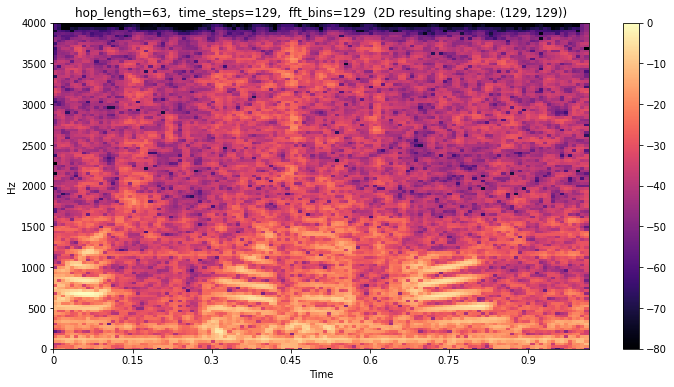

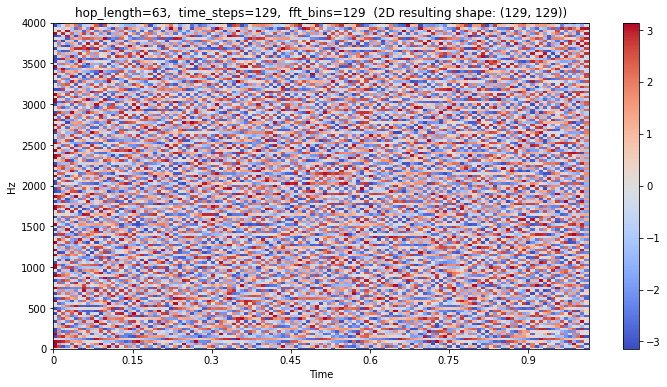

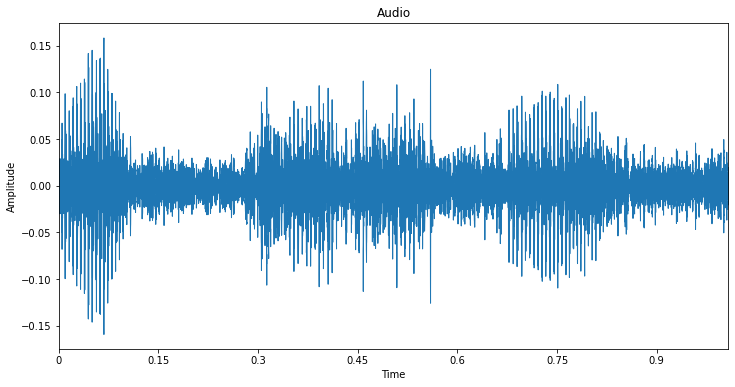

In [ ]:
# Display tools
def make_plot_spectrogram(stftaudio_magnitude_db,sample_rate, hop_length_fft) :
    """This function plots a spectrogram"""
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(stftaudio_magnitude_db, x_axis='time', y_axis='linear',
                             sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    title = 'hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
    plt.title(title.format(hop_length_fft,
                           stftaudio_magnitude_db.shape[1],
                           stftaudio_magnitude_db.shape[0],
                           stftaudio_magnitude_db.shape));
    return

def make_plot_phase(stft_phase,sample_rate,hop_length_fft) :
    """This function plots the phase in radian"""
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(np.angle(stft_phase), x_axis='time', y_axis='linear',
                             sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    title = 'hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
    plt.title(title.format(hop_length_fft,
                           stft_phase.shape[1],
                           stft_phase.shape[0],
                           stft_phase.shape));
    return

def make_plot_time_serie(audio,sample_rate):
    """This function plots the audio as a time serie"""
    plt.figure(figsize=(12, 6))
    #plt.ylim(-0.05, 0.05)
    plt.title('Audio')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveplot(audio, sr=sample_rate)
    return

# Display a sample frame
frame_id=2

print("Spectrogram")
make_plot_spectrogram(m_amp_db_noisy_voice[frame_id,:,:],sample_rate, hop_length_fft)
print("Phase")
make_plot_phase(m_pha_noisy_voice[frame_id,:,:],sample_rate,hop_length_fft)
print("Time series")
make_plot_time_serie(noisy_voice[frame_id,:],sample_rate)

## Convert to .h5 format, [train, val, test] split

In [ ]:
import numpy as np
import h5py

In [ ]:
main = "/content/drive/MyDrive/Projects/speech/dataset/STFT_amp_dB"

In [ ]:
train_amp = []
val_amp = []

for SNR in ["0","5","10"]:

    hf = h5py.File(main + '/' + 'SNR_' + SNR + 'dB/TRAIN/SNR_' + SNR + 'dB_TRAIN_hop128.h5', 'r')
    print(hf.keys())
    t = hf.get("SNR_" + SNR + "dB_TRAIN")
    t = np.array(t)
    print(t.shape)
    print(t.dtype)
    train_amp.append(t[:70000,:,:])
    val_amp.append(t[70000:,:,:])
    hf.close()

train_amp = np.vstack(train_amp)
print(train_amp.shape)

val_amp = np.vstack(val_amp)
print(val_amp.shape)

In [ ]:
train_amp_target = []
val_amp_target = []

hf = h5py.File(main + "/" + "voice_only/TRAIN/voice_only_TRAIN_hop128.h5", 'r')
print(hf.keys())
t = hf.get("voice_only_TRAIN")
t = np.array(t)
print(t.shape)
print(t.dtype)
hf.close()

for i in range(3):
    train_amp_target.append(t[:70000,:])
    val_amp_target.append(t[70000:,:])

train_amp_target = np.vstack(train_amp_target)
print(train_amp_target.shape)

val_amp_target = np.vstack(val_amp_target)
print(val_amp_target.shape)    

In [ ]:
# Save

with h5py.File(main + "/" + "train" "_hop128.h5", 'w') as hf:
    hf.create_dataset("train_amp",  data = train_amp)
    hf.create_dataset("train_amp_target",  data = train_amp_target)

In [ ]:
with h5py.File(main + "/" + "val" "_hop128.h5", 'w') as hf:
    hf.create_dataset("val_amp",  data = val_amp)
    hf.create_dataset("val_amp_target",  data = val_amp_target)

In [ ]:
hf = h5py.File(main + "/" + "train" "_hop128.h5",'r')
print(hf.keys())

In [ ]:
test_amp ={}

for SNR in ["0","10","2","5","7","n3"]:

    hf = h5py.File(main + '/' + 'SNR_' + SNR + 'dB/TEST/SNR_' + SNR + 'dB_TEST_hop128.h5', 'r')
    print(hf.keys())
    t = hf.get("SNR_" + SNR + "dB_TEST")
    test_amp[SNR] = np.array(t)
    print(t.shape)
    print(t.dtype)
    hf.close()

hf = h5py.File(main + "/" + "voice_only/TEST/voice_only_TEST_hop128.h5", 'r')
print(hf.keys())
t = hf.get("voice_only_TEST")
t = np.array(t)
print(t.shape)
print(t.dtype)
hf.close()

with h5py.File(main + "/" + "test" "_hop128.h5", 'w') as hf:
    for SNR in ["0","10","2","5","7","n3"]:
        hf.create_dataset("test_amp_" + SNR , data = test_amp[SNR])

    hf.create_dataset("test_amp_target", data = t)

# test_amp = np.vstack(test_amp)
# print(test_amp.shape)

In [ ]:
main = "/content/drive/MyDrive/Projects/speech/dataset/STFT_pha"

test_pha ={}

for SNR in ["0","10","2","5","7","n3"]:

    hf = h5py.File(main + '/' + 'SNR_' + SNR + 'dB/TEST/SNR_' + SNR + 'dB_TEST_hop128.h5', 'r')
    print(hf.keys())
    t = hf.get("SNR_" + SNR + "dB_TEST")
    test_pha[SNR] = np.array(t)
    print(t.shape)
    print(t.dtype)
    hf.close()

hf = h5py.File(main + "/" + "voice_only/TEST/voice_only_TEST_hop128.h5", 'r')
print(hf.keys())
t = hf.get("voice_only_TEST")
t = np.array(t)
print(t.shape)
print(t.dtype)
hf.close()

with h5py.File(main + "/" + "test_pha" "_hop128.h5", 'w') as hf:
    for SNR in ["0","10","2","5","7","n3"]:
        hf.create_dataset("test_pha_" + SNR , data = test_pha[SNR])

    hf.create_dataset("test_pha_target", data = t)